<a href="https://colab.research.google.com/github/zmunilla/TFM/blob/main/3_Clasificaci%C3%B3n_lado_PEC4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CONEXIÓN CON GOOGLE DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**INSTALAMOS LOS PAQUETES NECESARIOS**

In [ ]:
pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 129.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 103.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvji

**CARGAMOS LAS LIBRERÍAS NECESARIAS**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, average_precision_score
import matplotlib.pyplot as plt

**FUNCION DE TRANSFORMACIÓN DE IMÁGENES Y CREACIÓN DATASETS Y DATALOADERS**

In [ ]:
# Función de redimensionar sin deformar

from torchvision.transforms import functional as TF

class ResizeWithPadding:
    def __init__(self, size, fill=0):
        self.size = size
        self.fill = fill

    def __call__(self, img):
        w, h = img.size
        target_h, target_w = self.size
        scale = min(target_w / w, target_h / h)
        new_w, new_h = int(w * scale), int(h * scale)

        img = TF.resize(img, (new_h, new_w))

        pad_left = (target_w - new_w) // 2
        pad_top = (target_h - new_h) // 2
        pad_right = target_w - new_w - pad_left
        pad_bottom = target_h - new_h - pad_top

        img = TF.pad(img, [pad_left, pad_top, pad_right, pad_bottom], fill=self.fill)
        return img


#los bordes de las imágenes que hay que rellenar para completar el tamaño se rellenan
#con color negro

In [ ]:
#Establezco tamaño necesario de imagen para ResNet50. Se redimensiona, se transforma a tensor
#y se normalizan los recortes de aletas

resize_pad = ResizeWithPadding((224, 224))  # Resize sin deformación
transforma = transforms.Compose([
    resize_pad,
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [ ]:
# Creo datasets y dataloeaders

data_dir = '/content/drive/MyDrive/TFM/Lado/data_def'

train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transforma)
val_data = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transforma)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transforma)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)


**CONFIGURACIÓN DEL MODELO**

In [ ]:
#Definimos épocas y tamaño de lote

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10
batch_size = 32


# Modelo

model_side = models.resnet50(weights=ResNet50_Weights.DEFAULT) #pesos de red preentrenada
model_side.fc = nn.Linear(model_side.fc.in_features, 2) # se modifica la última capa totalmente conectada
#para que tenga dos salidas (derecha e izquierda)
model_side.to(device)

#Definimos función de pérdida y optimizador

loss_fn = nn.CrossEntropyLoss() #función de pérdida Cross Entropy
optimizer = optim.Adam(model_side.parameters(), lr=0.001) #Optimizador Adama con TA=0.001


**ENTRENAMIENTO Y VALIDACIÓN**

In [ ]:
#ENTRENAMIENTO

#Creamos las listas de métricas
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0
best_val_loss = float('inf')

for epoch in range(epochs):
    model_side.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model_side(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

# VALIDACIÓN

    model_side.eval()
    val_loss_sum, val_correct, val_total = 0.0, 0, 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = model_side(val_inputs)
            val_loss = loss_fn(val_outputs, val_labels)

            val_loss_sum += val_loss.item()
            _, val_preds = torch.max(val_outputs, 1)
            val_correct += (val_preds == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_loss = val_loss_sum / len(val_loader)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} - "
          f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if (val_acc > best_val_acc) or (val_acc == best_val_acc and val_loss < best_val_loss):
        best_val_acc = val_acc
        best_val_loss = val_loss
        torch.save(model_side.state_dict(), '/content/drive/MyDrive/TFM/PEC4/model_side_weights10_def.pth')
        print(f"✔ Modelo mejorado guardado con val_acc: {val_acc:.4f}, val_loss: {val_loss:.4f}")

#Se guarda el mejor modelo en base a la precisión en el conjunto de validación.

print(f"\n✅ Mejor precisión de validación: {best_val_acc:.4f}")

**VISUALIZAR GRÁFICAS DE ENTRENAMIENTO**

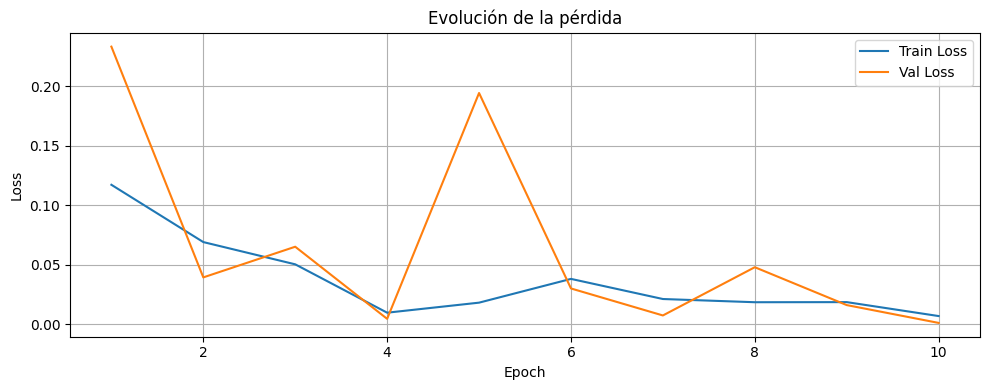

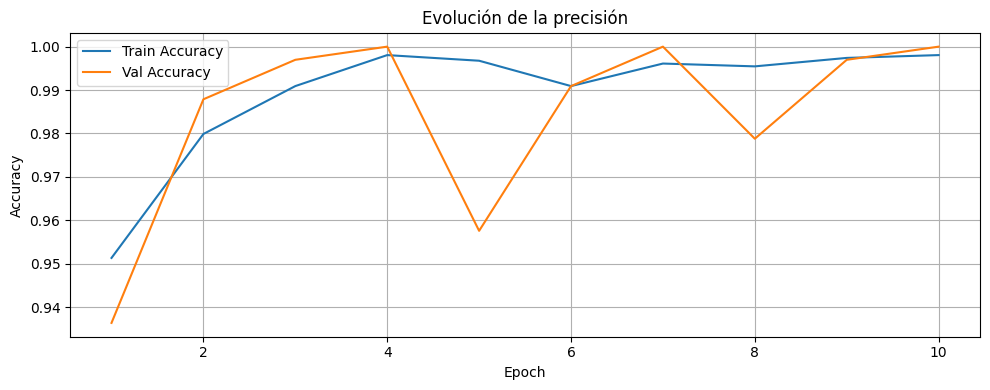

In [ ]:
epochs_range = list(range(1, len(train_losses) + 1))

# Plot loss
plt.figure(figsize=(10, 4))
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evolución de la pérdida')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 4))
plt.plot(epochs_range, train_accuracies, label='Train Accuracy')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Evolución de la precisión')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**CARGA DEL MODELO CON LOS PESOS OPTIMIZADOS**

In [ ]:
# Cargar modelo con los pesos entrenados
model_side.load_state_dict(torch.load('/content/drive/MyDrive/TFM/PEC4/model_side_weights10.pth', map_location=device))

<All keys matched successfully>

EVALUACIÓN DEL MODELO CON EL CONJUNTO DE TEST

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

model_side.eval()  # modelo en modo evaluación
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_side(inputs)

        # Obtener predicciones
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convertir a arrays de numpy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calcular métricas
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')
cm = confusion_matrix(all_labels, all_preds)

# Mostrar resultados
print(f"✅ Evaluación sobre el conjunto de test:")
print(f"Accuracy:  {accuracy * 100:.2f}%")
print(f"Recall:    {recall * 100:.2f}%")
print(f"F1-score:  {f1 * 100:.2f}%")
print("\nMatriz de confusión:")
print(cm)

# Reporte completo por clase
print("\nReporte por clase:")
print(classification_report(
    all_labels,
    all_preds,
    target_names=['Left', 'Right'],
    digits=3
))

**VISUALIZACIÓN MATRIZ DE CONFUSIÓN DE CONJUNTO TEST**

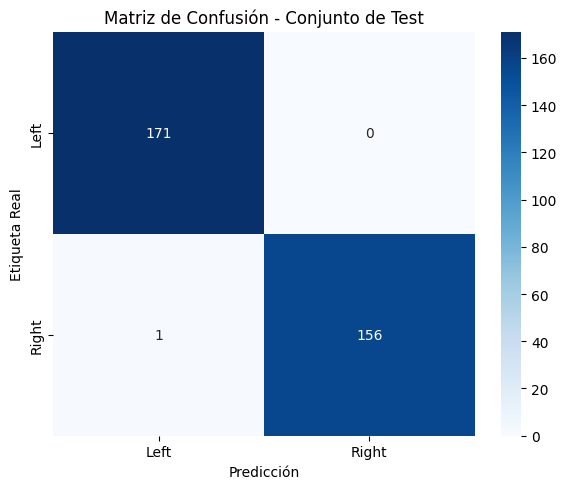

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Etiquetas de clase
labels = ['Left', 'Right']

# Crear figura
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Predicción')
plt.ylabel('Etiqueta Real')
plt.title('Matriz de Confusión - Conjunto de Test')
plt.tight_layout()
plt.show()
